In [174]:
import numpy as np
from tensorflow import keras
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler

In [175]:
mnist = keras.datasets.mnist

In [176]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [177]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [178]:
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [179]:
scaler = MinMaxScaler()

In [180]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [181]:
import matplotlib.pyplot as plt

(array([639.,  11.,   6.,  11.,   6.,   9.,  11.,  12.,  11.,  68.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

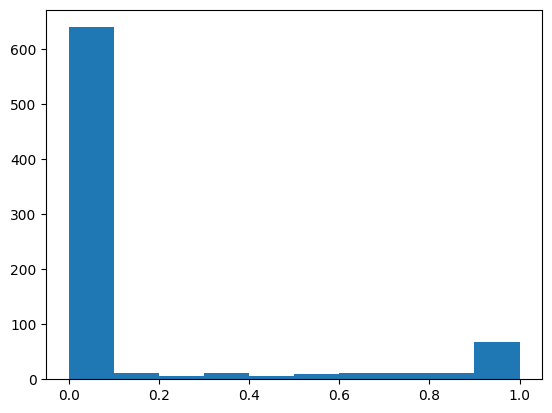

In [182]:
plt.hist(x_train[0])

# Net 만들기

In [183]:
def he_init(n_in, n_out):
    return np.random.randn(n_in, n_out)/np.sqrt(n_in/2)

In [184]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

In [185]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

In [186]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [187]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [188]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

In [189]:
class MnistNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        
        # 가중치 초기화 
        self.params = {}
        self.params['W1'] = weight_init_std * he_init(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * he_init(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['ReLU1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

In [190]:
net = MnistNet(input_size=784, hidden_size=50, output_size=10)

In [191]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

In [192]:
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]

    grad = net.gradient(x_batch, y_batch)

    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        net.params[key] -= learning_rate * grad[key]

    loss = net.loss(x_batch, y_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = net.accuracy(x_train, y_train)
        test_acc = net.accuracy(x_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.11236666666666667 0.1135
0.8975833333333333 0.9012
0.9208666666666666 0.9236
0.9316333333333333 0.9324
0.94135 0.9398
0.94895 0.946
0.95545 0.9526
0.9597833333333333 0.957
0.9633333333333334 0.9589
0.9662333333333334 0.9621
0.9688833333333333 0.9626
0.9706666666666667 0.965
0.9723166666666667 0.966
0.9739666666666666 0.9683
0.9742166666666666 0.9664
0.9771333333333333 0.9692
0.9781166666666666 0.968
